<h1>[GD_02]CutMix 또는 Mixup 비교 실험하기</h1>

1. CutMix와 MixUp기법을 ResNet50 분류기에 성공적으로 적용하였는가?<br>
2. 다양한 실험을 통해 테스크에 최적인 Augmentation기법을 찾아내었는가?<br>
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교 분석하였는가?<br>

<h2> Import Libraries</h2>

In [1]:
#TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

Tensorflow가 활용할 GPU가 장착되어 있는지 확인해보겠습니다

In [2]:
# GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h2> Load Data</h2>

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    shuffle_files=True,
    with_info = True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.

In [4]:
 print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


데이터의 개수도 확인해봅니다

In [5]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [6]:
ds_info.features['label'].num_classes

120

In [7]:
ds_info.features['label'].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

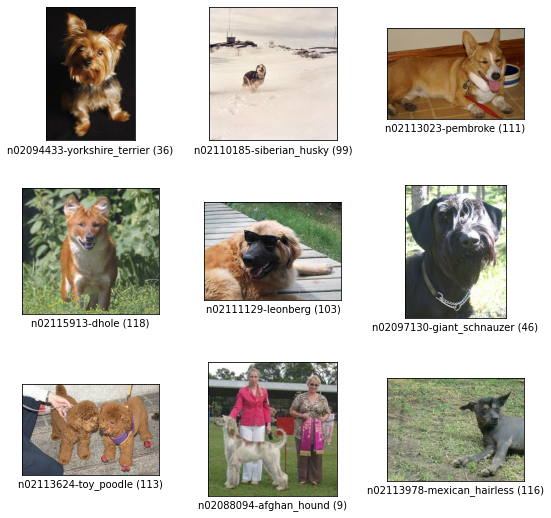

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

<h2> Augmentation 적용하기</h2>

In [9]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [10]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [11]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [12]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [13]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

<h2> 비교실험하기</h2>

In [14]:
num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문에 fully connected layer를 붙여 활용한다.

Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어줍니다.

In [15]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [16]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [17]:
print(ds_train_no_aug)
print(ds_test)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>


In [18]:
EPOCH = 40  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

resnet50.compile(
    loss='categorical_crossentropy',#loss를 'sparse_categorical_crossentropy'로 할경우 error발생
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/40
750/750 [==============================] - 210s 218ms/step - loss: 2.1844 - accuracy: 0.4471 - val_loss: 2.9540 - val_accuracy: 0.2629
Epoch 2/40
750/750 [==============================] - 150s 200ms/step - loss: 0.7728 - accuracy: 0.7784 - val_loss: 1.1974 - val_accuracy: 0.6564
Epoch 3/40
750/750 [==============================] - 149s 199ms/step - loss: 0.2422 - accuracy: 0.9488 - val_loss: 0.9716 - val_accuracy: 0.7127
Epoch 4/40
750/750 [==============================] - 150s 200ms/step - loss: 0.0671 - accuracy: 0.9941 - val_loss: 0.9160 - val_accuracy: 0.7318
Epoch 5/40
750/750 [==============================] - 150s 199ms/step - loss: 0.0294 - accuracy: 0.9989 - val_loss: 0.9098 - val_accuracy: 0.7395
Epoch 6/40
750/750 [==============================] - 150s 200ms/step - loss: 0.0171 - accuracy: 0.9997 - val_loss: 0.9217 - val_accuracy: 0.7404
Epoch 7/40
750/750 [==============================] - 150s 199ms/step - loss: 0.0124 - accuracy: 0.9998 - val_loss: 0.9339 -

In [19]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
750/750 [==============================] - 157s 200ms/step - loss: 2.2839 - accuracy: 0.4312 - val_loss: 2.9127 - val_accuracy: 0.2810
Epoch 2/40
750/750 [==============================] - 149s 199ms/step - loss: 0.9458 - accuracy: 0.7322 - val_loss: 1.2885 - val_accuracy: 0.6319
Epoch 3/40
750/750 [==============================] - 149s 199ms/step - loss: 0.5831 - accuracy: 0.8339 - val_loss: 1.1877 - val_accuracy: 0.6604
Epoch 4/40
750/750 [==============================] - 149s 199ms/step - loss: 0.3044 - accuracy: 0.9218 - val_loss: 1.0539 - val_accuracy: 0.6973
Epoch 5/40
750/750 [==============================] - 149s 199ms/step - loss: 0.1560 - accuracy: 0.9701 - val_loss: 1.0924 - val_accuracy: 0.6926
Epoch 6/40
750/750 [==============================] - 149s 199ms/step - loss: 0.0838 - accuracy: 0.9868 - val_loss: 0.9796 - val_accuracy: 0.7275
Epoch 7/40
750/750 [==============================] - 149s 199ms/step - loss: 0.0533 - accuracy: 0.9941 - val_loss: 0.9577 -

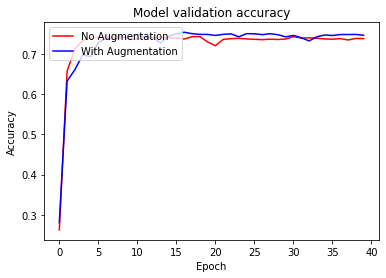

In [20]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

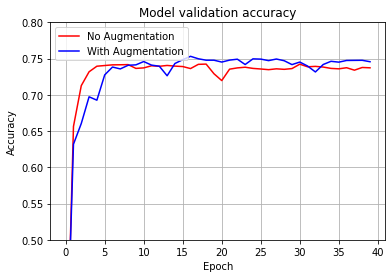

In [21]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

<h2> 심화기법 (1)Cutmix Augmentation</h2>

<h3>CutMix 논문 리뷰</h3>

CutMix는 Mixup/Cutout에서 더 나아가 cut-and-paste 방법을 취해 이미지 일부분을 다른 이미지의 패치로 채우는 기법으로 image classification, weakly-supervised localization task 등에서 일관된 높은 성능을 거두었다고 합니다.

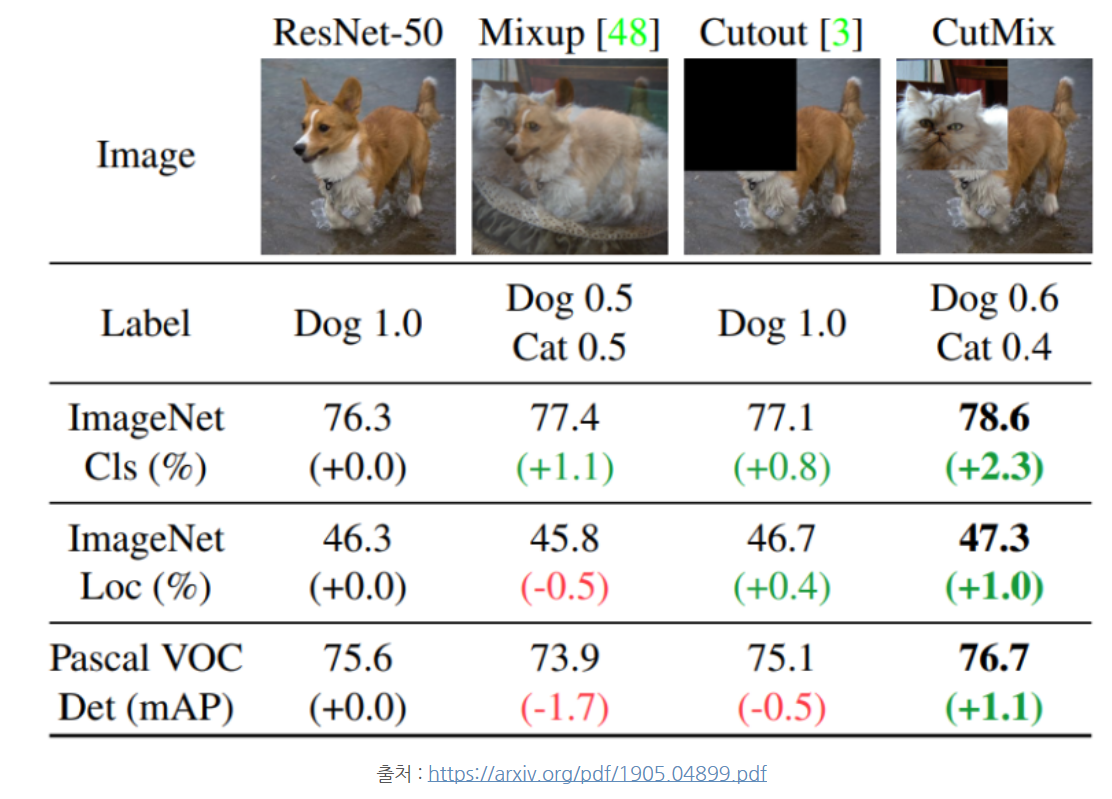

 - 각 이미지들을 랜덤으로 잘라줄 부분이 필요한데 이것을 rand_bbox()함수에서 진행한다. x,y,w,h 값을 랜덤하게 뽑아내어 출력으로 만들어준다.<br>
 - CutMix가 적용되는 이미지도 랜덤으로 지정해준다. 파라미터로 넣어 어느정도의 비율로 CutMix 이미지를 만들어낼지 명시하게 된다. 여기서는 0.5를 사용한다.<br>

<h3>1) 이미지 섞기</h3>

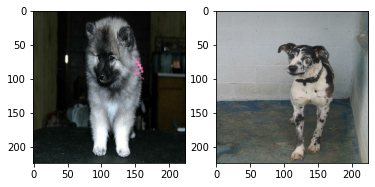

In [22]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [23]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(43, shape=(), dtype=int32) tf.Tensor(163, shape=(), dtype=int32)
y :  tf.Tensor(29, shape=(), dtype=int32) tf.Tensor(159, shape=(), dtype=int32)


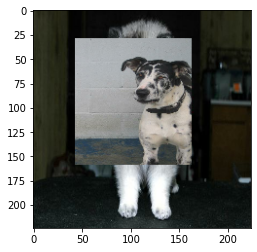

In [31]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

<h3>2) 라벨 섞기</h3>

In [32]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

In [33]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

<h2> 심화기법 (2)Mixup Augmentation</h2>

Mixup은 그 중 데이터증강(Data Augmentation)과 관련된 기술 중 하나로, 학습 데이터에서 두 개의 샘플 데이터를 혼합(Mix)하여 새로운 학습데이터를 만드는 기술입니다.

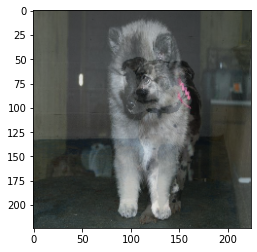

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.3725239 0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [34]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [35]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

<h1> 프로젝트: CutMix 또는 Mixup 비교실험하기 </h1>

지금까지 기본적인 augmentation방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.<br>
<br>
이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜주세요. 결과를 수치화하고 비교하는 것도 잊지 마세요!

<h2>1. Augmentation을 적용한 데이터셋 만들기</h2>

In [36]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )

    if not is_test and with_aug:
        ds = ds.map(
            augment
        )

    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )

    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds


<h2>2. 모델 만들기</h2>

앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요.<br>
모델은 ResNet-50을 사용합시다.

In [37]:
(ds_train,ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    as_supervised = True,
    shuffle_files = True,
    with_info = True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train,with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train,with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train,with_cutmix=True)
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train,with_aug=True,with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train,with_mixup=True)
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train,with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test,is_test=True)

해당 노드에서 with_mixup이 없어서 추가하였습니다
(왜 없는건지....)

In [38]:
# No Augmentation

num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [39]:
# 기본 Augmentation

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [40]:
# No Augmentation + CutMix

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [41]:
# 기본 Augmentation + CutMix

aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [42]:
# No Augmentation + Mixup

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [43]:
# 기본 Augmentation + Mixup

aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

<h2>3. 모델 훈련하기</h2>

In [44]:
# ResNet 50 (No Augmentation)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 기본 Augumentation
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# No Augmentation + cutmix
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 기본 Augmentation + cutmix
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# No Augmentation + mixup
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 기본 Augmentation + mixup
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [45]:
EPOCH = 20

# ResNet 50 (No Augmentation) 학습

history_resnet50_no_aug = resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 157s 201ms/step - loss: 2.2839 - accuracy: 0.4299 - val_loss: 2.9721 - val_accuracy: 0.2639
Epoch 2/20
750/750 [==============================] - 149s 199ms/step - loss: 0.9495 - accuracy: 0.7313 - val_loss: 1.2189 - val_accuracy: 0.6498
Epoch 3/20
750/750 [==============================] - 149s 199ms/step - loss: 0.5107 - accuracy: 0.8627 - val_loss: 1.2748 - val_accuracy: 0.6426
Epoch 4/20
750/750 [==============================] - 149s 199ms/step - loss: 0.2565 - accuracy: 0.9408 - val_loss: 0.9863 - val_accuracy: 0.7183
Epoch 5/20
750/750 [==============================] - 149s 199ms/step - loss: 0.1449 - accuracy: 0.9708 - val_loss: 1.0771 - val_accuracy: 0.6972
Epoch 6/20
750/750 [==============================] - 149s 199ms/step - loss: 0.0782 - accuracy: 0.9889 - val_loss: 1.0068 - val_accuracy: 0.7179
Epoch 7/20
750/750 [==============================] - 149s 199ms/step - loss: 0.0530 - accuracy: 0.9927 - val_loss: 0.9954 -

In [46]:
# 기본 Augumentation

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 173s 221ms/step - loss: 2.2695 - accuracy: 0.4341 - val_loss: 2.9118 - val_accuracy: 0.2882
Epoch 2/20
750/750 [==============================] - 149s 199ms/step - loss: 0.9691 - accuracy: 0.7193 - val_loss: 1.1726 - val_accuracy: 0.6509
Epoch 3/20
750/750 [==============================] - 149s 199ms/step - loss: 0.5167 - accuracy: 0.8606 - val_loss: 1.1233 - val_accuracy: 0.6791
Epoch 4/20
750/750 [==============================] - 149s 199ms/step - loss: 0.2781 - accuracy: 0.9319 - val_loss: 1.1292 - val_accuracy: 0.6771
Epoch 5/20
750/750 [==============================] - 149s 199ms/step - loss: 0.1540 - accuracy: 0.9707 - val_loss: 1.0631 - val_accuracy: 0.7007
Epoch 6/20
750/750 [==============================] - 149s 199ms/step - loss: 0.0844 - accuracy: 0.9858 - val_loss: 0.9733 - val_accuracy: 0.7317
Epoch 7/20
750/750 [==============================] - 149s 199ms/step - loss: 0.0517 - accuracy: 0.9942 - val_loss: 0.9494 -

In [47]:
# No Augmentation + cutmix

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 157s 201ms/step - loss: 2.2739 - accuracy: 0.4268 - val_loss: 2.7935 - val_accuracy: 0.3078
Epoch 2/20
750/750 [==============================] - 149s 199ms/step - loss: 0.9519 - accuracy: 0.7311 - val_loss: 1.1799 - val_accuracy: 0.6566
Epoch 3/20
750/750 [==============================] - 149s 199ms/step - loss: 0.4933 - accuracy: 0.8680 - val_loss: 1.1091 - val_accuracy: 0.6805
Epoch 4/20
750/750 [==============================] - 149s 199ms/step - loss: 0.2594 - accuracy: 0.9363 - val_loss: 1.0235 - val_accuracy: 0.7093
Epoch 5/20
750/750 [==============================] - 150s 199ms/step - loss: 0.1382 - accuracy: 0.9743 - val_loss: 1.0519 - val_accuracy: 0.7127
Epoch 6/20
750/750 [==============================] - 150s 199ms/step - loss: 0.0810 - accuracy: 0.9881 - val_loss: 0.9849 - val_accuracy: 0.7275
Epoch 7/20
750/750 [==============================] - 149s 199ms/step - loss: 0.0528 - accuracy: 0.9933 - val_loss: 1.0169 -

In [48]:
# 기본 Augmentation + cutmix

history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 157s 201ms/step - loss: 2.2828 - accuracy: 0.4265 - val_loss: 2.9141 - val_accuracy: 0.2812
Epoch 2/10
750/750 [==============================] - 165s 220ms/step - loss: 0.9452 - accuracy: 0.7278 - val_loss: 1.2786 - val_accuracy: 0.6263
Epoch 3/10
750/750 [==============================] - 149s 199ms/step - loss: 0.4954 - accuracy: 0.8652 - val_loss: 1.0406 - val_accuracy: 0.6945
Epoch 4/10
750/750 [==============================] - 149s 199ms/step - loss: 0.2693 - accuracy: 0.9348 - val_loss: 1.1289 - val_accuracy: 0.6807
Epoch 5/10
750/750 [==============================] - 149s 199ms/step - loss: 0.1494 - accuracy: 0.9704 - val_loss: 1.0027 - val_accuracy: 0.7196
Epoch 6/10
750/750 [==============================] - 149s 199ms/step - loss: 0.0810 - accuracy: 0.9875 - val_loss: 0.9802 - val_accuracy: 0.7233
Epoch 7/10
750/750 [==============================] - 149s 199ms/step - loss: 0.0561 - accuracy: 0.9922 - val_loss: 0.9652 -

In [49]:
# No Augmentation + mixup

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 173s 221ms/step - loss: 2.2693 - accuracy: 0.4347 - val_loss: 2.9761 - val_accuracy: 0.2661
Epoch 2/10
750/750 [==============================] - 149s 199ms/step - loss: 0.9575 - accuracy: 0.7284 - val_loss: 1.3405 - val_accuracy: 0.6109
Epoch 3/10
750/750 [==============================] - 149s 199ms/step - loss: 0.5021 - accuracy: 0.8590 - val_loss: 1.0277 - val_accuracy: 0.6944
Epoch 4/10
750/750 [==============================] - 149s 199ms/step - loss: 0.2611 - accuracy: 0.9390 - val_loss: 0.9853 - val_accuracy: 0.7164
Epoch 5/10
750/750 [==============================] - 149s 199ms/step - loss: 0.1419 - accuracy: 0.9730 - val_loss: 1.1617 - val_accuracy: 0.6796
Epoch 6/10
750/750 [==============================] - 149s 199ms/step - loss: 0.0823 - accuracy: 0.9874 - val_loss: 1.0059 - val_accuracy: 0.7213
Epoch 7/10
750/750 [==============================] - 149s 199ms/step - loss: 0.0495 - accuracy: 0.9940 - val_loss: 0.9593 -

In [50]:
# 기본 Augmentation + mixup

history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 156s 200ms/step - loss: 2.2574 - accuracy: 0.4297 - val_loss: 3.3358 - val_accuracy: 0.2060
Epoch 2/10
750/750 [==============================] - 149s 199ms/step - loss: 0.9298 - accuracy: 0.7319 - val_loss: 1.1718 - val_accuracy: 0.6613
Epoch 3/10
750/750 [==============================] - 149s 199ms/step - loss: 0.4969 - accuracy: 0.8642 - val_loss: 1.1926 - val_accuracy: 0.6597
Epoch 4/10
750/750 [==============================] - 149s 199ms/step - loss: 0.2614 - accuracy: 0.9398 - val_loss: 0.9785 - val_accuracy: 0.7160
Epoch 5/10
750/750 [==============================] - 149s 199ms/step - loss: 0.1458 - accuracy: 0.9712 - val_loss: 0.9869 - val_accuracy: 0.7190
Epoch 6/10
750/750 [==============================] - 149s 198ms/step - loss: 0.0824 - accuracy: 0.9875 - val_loss: 0.9957 - val_accuracy: 0.7248
Epoch 7/10
750/750 [==============================] - 149s 199ms/step - loss: 0.0493 - accuracy: 0.9937 - val_loss: 0.9429 -

<h2>4. 훈련 과정 시각화하기</h2>

훈련 과정의 히스토리를 그래프로 시각화해주세요.

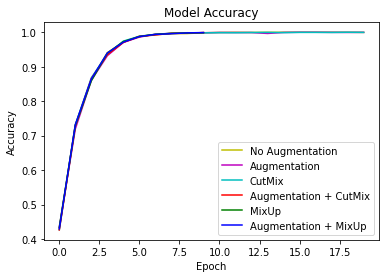

In [51]:
# Training Accuracy

plt.plot(history_resnet50_no_aug.history['accuracy'], 'y')
plt.plot(history_resnet50_aug.history['accuracy'], 'm')
plt.plot(history_resnet50_cutmix.history['accuracy'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'b')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='lower right')
plt.show()     

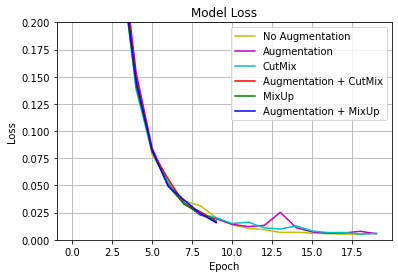

In [52]:
# Validation Loss

plt.plot(history_resnet50_no_aug.history['loss'], 'y')
plt.plot(history_resnet50_aug.history['loss'], 'm')
plt.plot(history_resnet50_cutmix.history['loss'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'r')
plt.plot(history_resnet50_mixup.history['loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'b')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='upper right')
plt.grid(True)
plt.ylim(0, 0.2)
plt.show()

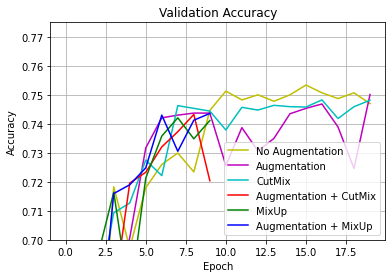

In [53]:
# Validation Accuracy

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'm')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'b')

plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='lower right')
plt.grid(True)
plt.ylim(0.7, 0.775)
plt.show()

<h2>Augmentation에 의한 모델 성능 비교</h2>

·Training Accuracy,Validation Loss 그래프를 살펴보았을 때 성능면에 있어서 큰 차이가 없는 것을 확인할 수 있었다.<br>
·학습을 적게 진행했을 때에는 augmentation을 적용하지 않은 모델이 augmentation을 적용한 모델보다 성능이 더 높게 나온 경우를 보았다.<br>
-> 결론은 효율성 면에서 보았을 때 사용하지 않는게 낫지 않았을까 싶다.

<h2>회고</h2>

이번 프로젝트에서 크게 걸리는 부분은 없었지만 시간 할애가 너무 많이 되서 그 부분이 많이 힘들었다. 결국 마지막 3가지 cell에서는 시간이 없는 관계로 epoch를 20에서 10으로 줄여서 진행하였다. 그리고 모델 만들기 부분에서 with mixup 인자가 없어서 다른 곳에서 찾아서 참고하여 코드를 작성하였다. 생각보다 여기저기 error가 발생할 곳이 있었던 것 같다.<br>
<br>
시간이 더 있었다면 좀더 꼼꼼하게 모델을 살펴보고 실험을 진행할 수 있지 않았을까 생각한다. 시간 부족이 이번 프로젝트에서 가장 큰 이슈인 것 같다.<br>
<br>
이번 실험 이후에 좀더 시간을 투자해서 꼼꼼하게 살펴보고 만약 cutmix나 mixup이 효과가 뛰어나다면 앞으로 모델에 사용해볼 예정이다. 이후에는 argument에 대한 다른 모델이 있는지 좀더 확인해볼 예정이다.